In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

In [3]:
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk import  pos_tag, ne_chunk
from nltk.tree import Tree
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')



from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC



from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense , Bidirectional , GRU ,Conv1D, GlobalMaxPooling1D , Dropout , BatchNormalization , SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##**dataset 1**

In [4]:
dataset1 = pd.read_csv("/content/drive/MyDrive/grad/software_requirements_extended.csv")
dataset2 = pd.read_csv('/content/drive/MyDrive/grad/Dataset.csv')
dataset3=pd.read_csv('/content/drive/MyDrive/grad/nfr (1).csv')
dataset4=pd.read_csv('/content/drive/MyDrive/grad/PROMISE_exp.csv')

dataset2 = dataset2.drop(columns=['Scenario', 'Author'])
dataset3 = dataset3.drop(columns=['ProjectID'])
dataset4 = dataset4.drop(columns=['ProjectID'])

dataset2.rename(columns={'Requirement Type': 'Type'}, inplace=True)
dataset3.rename(columns={'RequirementText': 'Requirement'}, inplace=True)
dataset4.rename(columns={'RequirementText': 'Requirement'}, inplace=True)

dataset3.rename(columns={'class': 'Type'}, inplace=True)
dataset4.rename(columns={'_class_': 'Type'}, inplace=True)

dataset2['Type'] = dataset2['Type'].replace({'Functional': 'FR', 'Nonfunctional': 'NFR'})
categories_to_replace = ['PE' , 'LF' , 'US' , 'A' , 'SE' , 'FT' , 'SC' , 'PO' , 'O' , 'L' , 'MN']
dataset3['Type'] = dataset3['Type'].replace(categories_to_replace, 'NFR')
dataset4['Type'] = dataset4['Type'].replace(categories_to_replace, 'NFR')
dataset1 = pd.concat([dataset1, dataset2, dataset3, dataset4], ignore_index=True)


dataset1['Type'] = dataset1['Type'].replace({'F': 'FR'})
categories_to_replace = ['A', 'FT', 'L', 'LF', 'MN', 'O', 'PE', 'PO', 'SC', 'SE', 'US']
dataset1['Type'] = dataset1['Type'].replace(categories_to_replace, 'NFR')
print("\nUnique requirement types in 'Type' column dataset 1:")
print(dataset1['Type'].unique())





Unique requirement types in 'Type' column dataset 1:
['NFR' 'FR']


In [5]:
print(dataset1.dtypes , dataset1.shape)

Type           object
Requirement    object
dtype: object (2971, 2)


In [6]:
print("Distribution of each requirement type:")
print(dataset1['Type'].value_counts())

Distribution of each requirement type:
Type
NFR    1551
FR     1420
Name: count, dtype: int64


In [7]:
print("\nUnique requirement types in 'Type' column:")
print(dataset1['Type'].unique())


Unique requirement types in 'Type' column:
['NFR' 'FR']


In [8]:
dataset_copy = dataset1.copy()

In [9]:
dataset_copy['Type'] = dataset_copy['Type'].replace({'F': 'FR'})
categories_to_replace = ['A', 'FT', 'L', 'LF', 'MN', 'O', 'PE', 'PO', 'SC', 'SE', 'US']
dataset_copy['Type'] = dataset_copy['Type'].replace(categories_to_replace, 'NFR')

## visualization


<ipython-input-10-caefe5801deb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset_copy, x='Type', order=dataset1['Type'].value_counts().index, palette='viridis')


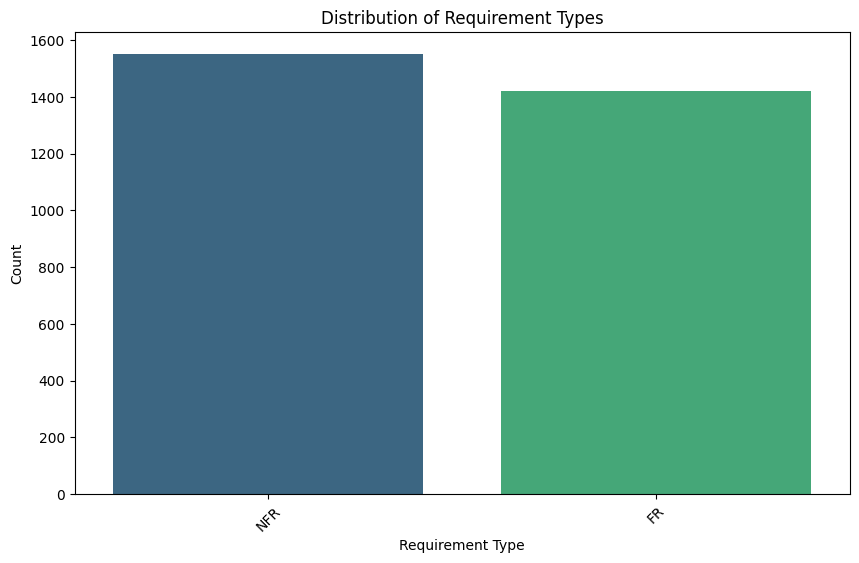

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset_copy, x='Type', order=dataset1['Type'].value_counts().index, palette='viridis')
plt.title("Distribution of Requirement Types")
plt.xlabel("Requirement Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


<ipython-input-11-f24551e50be6>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=category, palette='Set2')


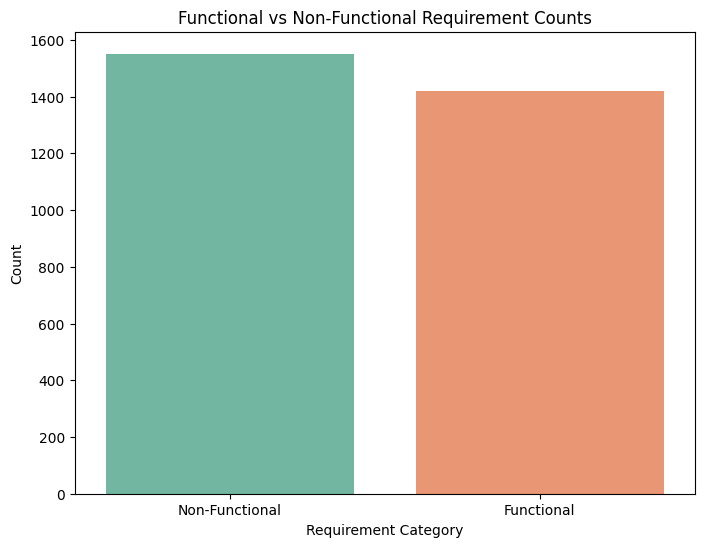

In [11]:
# Create a copy of the dataset to work with
functional_labels = ['F', 'FR']
# Apply the transformation to the copied dataset without altering the original
category = dataset_copy['Type'].apply(lambda x: 'Functional' if x in functional_labels else 'Non-Functional')

# Plot the counts
plt.figure(figsize=(8, 6))
sns.countplot(x=category, palette='Set2')
plt.title("Functional vs Non-Functional Requirement Counts")
plt.xlabel("Requirement Category")
plt.ylabel("Count")
plt.show()


Summary statistics for requirement lengths:


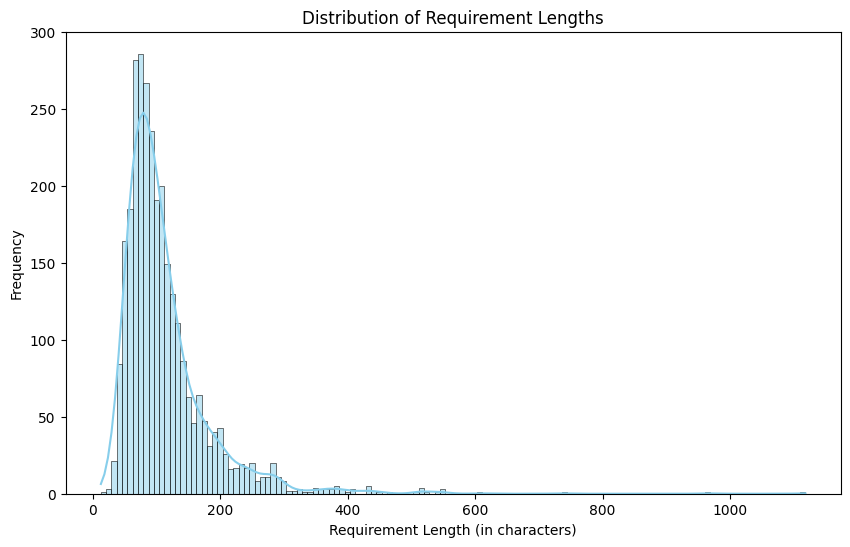

In [12]:
dataset_copy['Requirement_Length'] = dataset_copy['Requirement'].apply(len)
print("Summary statistics for requirement lengths:")
plt.figure(figsize=(10, 6))
sns.histplot(dataset_copy['Requirement_Length'], kde=True, color='skyblue')
plt.title("Distribution of Requirement Lengths")
plt.xlabel("Requirement Length (in characters)")
plt.ylabel("Frequency")
plt.show()

In [13]:
dataset_copy['Word_Count'] = dataset_copy['Requirement'].apply(lambda x: len(x.split()))   # Word count
dataset_copy['Character_Count'] = dataset_copy['Requirement'].apply(len)
print("Summary statistics for word counts:")
print(dataset_copy['Word_Count'].describe())
print("\nSummary statistics for character counts:")
print(dataset_copy['Character_Count'].describe())

Summary statistics for word counts:
count    2971.000000
mean       18.549983
std        11.783418
min         2.000000
25%        11.000000
50%        16.000000
75%        22.000000
max       179.000000
Name: Word_Count, dtype: float64

Summary statistics for character counts:
count    2971.000000
mean      113.694379
std        71.565215
min        13.000000
25%        72.000000
50%        95.000000
75%       132.000000
max      1118.000000
Name: Character_Count, dtype: float64


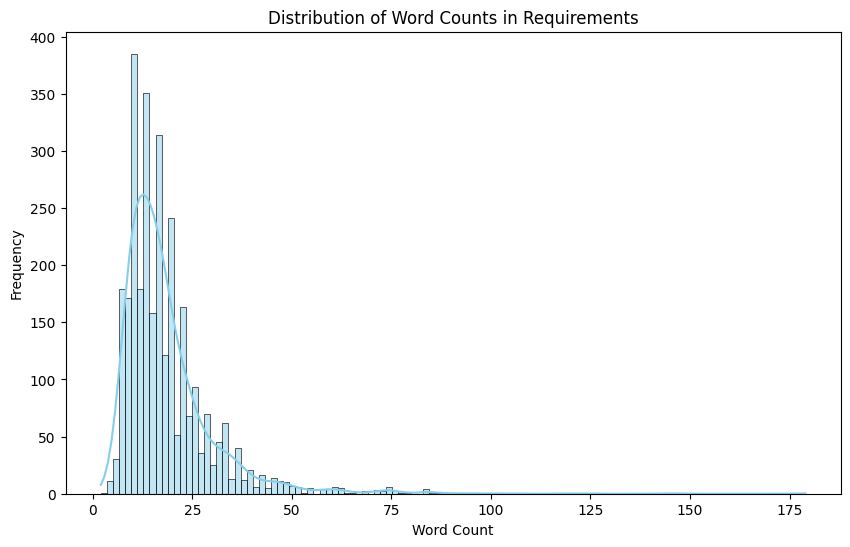

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset_copy['Word_Count'], kde=True, color='skyblue')
plt.title("Distribution of Word Counts in Requirements")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [15]:


# 1. Average Length of All Requirements
def average_length(dataset_copy):
    avg_length = dataset_copy['Requirement'].apply(len).mean()
    return avg_length

# 2. Textual Complexity Analysis
def textual_complexity(dataset_copy):
    word_lengths = dataset_copy['Requirement'].apply(lambda x: [len(word) for word in word_tokenize(x)])
    avg_word_length = word_lengths.apply(lambda x: sum(x) / len(x)).mean()
    sentence_counts = dataset_copy['Requirement'].apply(lambda x: len(sent_tokenize(x)))
    avg_sentence_length = dataset_copy['Requirement'].apply(lambda x: len(word_tokenize(x)) / len(sent_tokenize(x)))

    complexity_data = {
        'avg_word_length': avg_word_length,
        'avg_sentence_count': sentence_counts.mean(),
        'avg_sentence_length': avg_sentence_length.mean()
    }

    return complexity_data

# 3. Unique vs. Repeated Requirements
def unique_vs_repeated(dataset_copy):
    requirement_counts = dataset_copy['Requirement'].value_counts()
    repeated_requirements = requirement_counts[requirement_counts > 1]
    unique_requirements_count = len(requirement_counts[requirement_counts == 1])

    return {
        'total_requirements': len(dataset_copy),
        'unique_requirements': unique_requirements_count,
        'repeated_requirements': len(repeated_requirements),
        'repeated_requirements_list': repeated_requirements
    }

# Run the analyses
avg_length = average_length(dataset_copy)
complexity = textual_complexity(dataset_copy)
uniqueness = unique_vs_repeated(dataset_copy)

# Output results
print("Average Length of All Requirements:")
print(avg_length)

print("\nTextual Complexity:")
print(complexity)

print("\nUnique vs. Repeated Requirements:")
print(uniqueness)


Average Length of All Requirements:
113.69437899697071

Textual Complexity:
{'avg_word_length': 4.901137503688399, 'avg_sentence_count': 1.2154156849545608, 'avg_sentence_length': 16.375252039556987}

Unique vs. Repeated Requirements:
{'total_requirements': 2971, 'unique_requirements': 1363, 'repeated_requirements': 583, 'repeated_requirements_list': Requirement
User data should be regularly backup and stored safely                                                                                             8
The software should be updated regularly and compatible with technological progress                                                                8
Software should appeal to a wide audience by providing multiple language support.                                                                  7
The system should be scaled and can be easily adapted to increasing user demands.                                                                  7
A strong authentication system should b

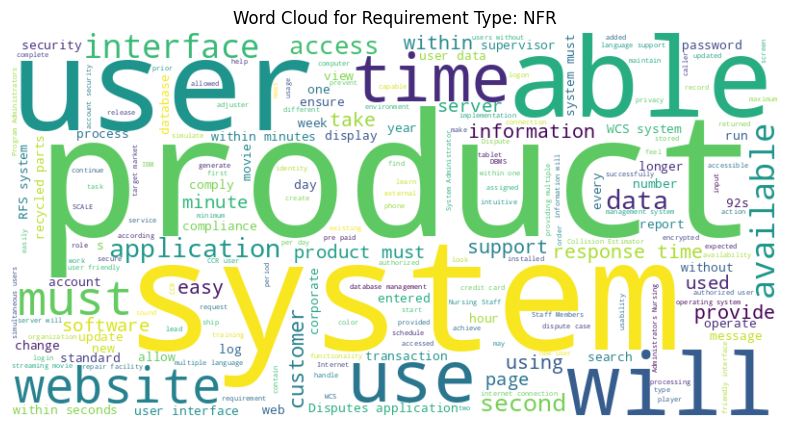

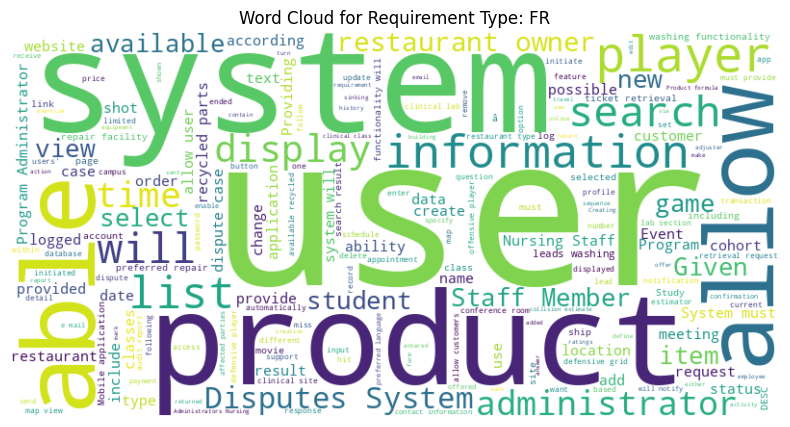

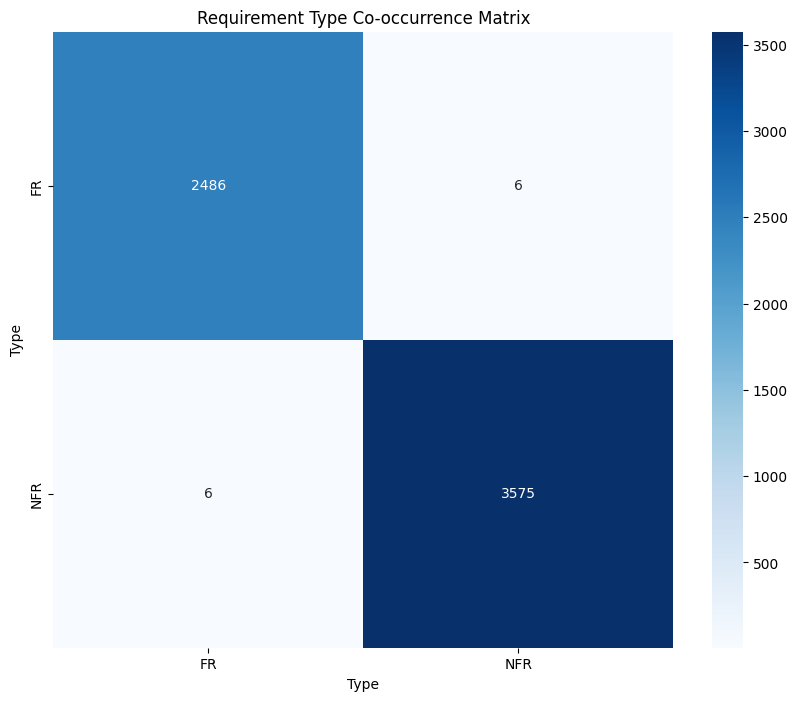

In [16]:

def generate_word_clouds_by_type(dataset_copy):
    requirement_types = dataset_copy['Type'].unique()

    for req_type in requirement_types:
        text = " ".join(requirement for requirement in dataset_copy[dataset_copy['Type'] == req_type]['Requirement'].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Requirement Type: {req_type}")
        plt.show()



# 3. Requirement Type Co-occurrence Matrix
def requirement_type_cooccurrence_matrix(dataset_copy):
    # This assumes a requirement can belong to multiple types, stored as lists in the 'requirement_type' column
    dataset_copy = dataset_copy.explode('Type')  # Splits multi-type entries
    co_occurrence = pd.crosstab(dataset_copy['Requirement'], dataset_copy['Type']).T.dot(
        pd.crosstab(dataset_copy['Requirement'], dataset_copy['Type'])
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues")
    plt.title("Requirement Type Co-occurrence Matrix")
    plt.show()

# Run visualizations
generate_word_clouds_by_type(dataset_copy)
requirement_type_cooccurrence_matrix(dataset_copy)

## missing check

In [17]:
# 1. Check for Missing / Incomplete Data
def check_missing_data(dataset_copy):
    missing_data = dataset_copy.isnull().sum()
    incomplete_rows = dataset_copy[dataset_copy.isnull().any(axis=1)]

    print("Missing Data Summary:")
    print(missing_data)
    print("\nRows with Incomplete Data:")
    print(incomplete_rows)

    return missing_data, incomplete_rows

missing_data, incomplete_rows = check_missing_data(dataset1)


Missing Data Summary:
Type           0
Requirement    0
dtype: int64

Rows with Incomplete Data:
Empty DataFrame
Columns: [Type, Requirement]
Index: []


##**test dataset**

In [18]:
testDataSet = pd.read_csv("/content/drive/MyDrive/grad/nfr-test.csv")
testDataSet

,Column1,Column2
0,F,The system shall display Events or Activities.
1,F,The display shall have two regions left 2/3 o...
2,F,The data displayed in both the nodes within th...
3,F,The table side of the display shall be split i...
4,F,The top 1/4 of the table will hold events that...
...,...,...
65,SE,The Disputes application shall manipulate and ...
66,SE,All updates to data files or database must be ...
67,L,The Disputes application must conform to the l...
68,L,All business rules specified in the Disputes S...


In [19]:
testDataSet.rename(columns={"Column1": "Type", "Column2": "Requirement"}, inplace=True)

In [20]:
testDataSet['Type'] = testDataSet['Type'].replace({'F': 'FR'})
categories_to_replace = ['LF' ,'US' ,'O' ,'SE' ,'L']
testDataSet['Type'] = testDataSet['Type'].replace(categories_to_replace, 'NFR')




##**Functions**

In [21]:
## lower casing

def lower_casing(df):
  df = df.map(lambda x: x.lower() if isinstance(x, str) else x)
  return df

newDS1=lower_casing(dataset_copy)
newTestDS=lower_casing(testDataSet.copy())


In [22]:
def extract_named_entities(text):
    words = word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    named_entities = nltk.ne_chunk(pos_tags, binary=False)
    entities = []
    for chunk in named_entities:
        if hasattr(chunk, 'label'):
            entities.append((chunk.label(), ' '.join(c[0] for c in chunk)))
    return entities

In [23]:
## removing non word and non whitespaces
def remover(df):
  df = df.replace(to_replace=r'[^\w\s]', value='', regex=True)
  return df

newDS1=remover(newDS1)
newTestDS=remover(newTestDS)

In [24]:
## removing digits
def digit_remover(df):
  df = df.replace(to_replace=r'\d', value='', regex=True)
  return df

newDS1=digit_remover(newDS1)
newTestDS=digit_remover(newTestDS)


In [25]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
## remove puncituation
def remove_punc(df,label):
  xx= []
  for i in range(len(df[label])):
    temp =df[label][i]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in temp.split()]
    stripped = ' '.join(stripped)
    xx.append(stripped)
  return xx

newDS1['Requirement']=remove_punc(newDS1,'Requirement')
newTestDS['Requirement']=remove_punc(newTestDS,'Requirement')



In [27]:
## before stepping into integration and tokenization phase we just make sure all our datasets have the same features
print(newDS1['Type'].unique())
print(newTestDS['Type'].unique())

['nfr' 'fr']
['fr' 'nfr']


In [28]:
## check if all sentences are written in english characters
def count_non_english_characters(df,label):
  count =[]
  for i in range(len(df[label])):
    non_english_chars = re.findall(r'[^a-zA-Z\s]', df[label][i])
    if non_english_chars:  print(non_english_chars , df[label][i])
    count.append(len(non_english_chars))
    # count = len(non_english_chars)
  return sum(count)  # Output: 8


In [29]:
## dataset 1
x=count_non_english_characters(newDS1,'Requirement')
print('Number of non english  characters : ' , x)

['â', 'â'] the twitter âtweetâ interface should be according to the twitter guidelines
['â', 'â'] the facebook âlikeâ interface should be according to the facebook guidelines
['â'] hard drive space gist hard drive space scale the applicationâs need of hard drive space meter mb must no more than mb plan no more than mb wish no more than mb mb defined megabyte
['â', 'œ', 'â', 'â'] design constraints we will use âœwaterfall methodâ and object â oriented programming paradigm we will use java as programming language the android version of the device should be or higher the system requires internet connection all the time
['â'] â the system will be designed in such a way that the algorithms for the four main units will be able to be easily swapped out
['â'] the overall accuracy of the web apiâs response will be measured using a developermade testing set
['â'] the accuracy of the generic question constructionâ part will be close to
['â', 'â', 'â', 'â', 'â', 'â', 'â', 'â', 'â', 'â', 'â', 'â'] 

In [30]:
##test dataset
z=count_non_english_characters(newTestDS,'Requirement')
print('Number of non english  characters : ' , z)

Number of non english  characters :  0


In [31]:
## removing the non english
def remove_non_english_characters(df,label):
  x=[]
  for i in range(len(df[label])):
    temp = df[label][i]
    non_english_chars = re.sub(r'[^a-zA-Z\s]', '', temp)
    x.append(non_english_chars)
  return x

newDS1['Requirement']=remove_non_english_characters(newDS1,'Requirement')
newTestDS['Requirement']=remove_non_english_characters(newTestDS,'Requirement')

## testing our work
print('Number of non english characters dataset 1 : ',count_non_english_characters(newDS1,'Requirement') ,'\nNumber of non english  characters : ',
count_non_english_characters(newTestDS,'Requirement'))

Number of non english characters dataset 1 :  0 
Number of non english  characters :  0


In [32]:


def remove_SW(ds,label):
  x = []
  for i in range(len(ds[label])):
    words = word_tokenize(ds[label][i])
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_sentence)
    x.append(filtered_sentence)
  return x


newDS1['Requirement']=remove_SW(newDS1,'Requirement')
newTestDS['Requirement']=remove_SW(newTestDS,'Requirement')




In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
newDS1['Type'] = label_encoder.fit_transform(newDS1['Type'])
newTestDS['Type'] = label_encoder.fit_transform(newTestDS['Type'])





stemming :  Convert words to their base forms to reduce redundancy.

lemmatization :  Convert words to their base forms to reduce redundancy.

named entity recognition :  Identify entities such as people, systems, dates, etc., which could be crucial in defining use cases.



## **Note** : that the differnece between stemming and lemmatization is that

1 ) meaning
stemming : meaning isn't important to me or the proccess
lemmatization : meaning is very important ans=d can actually determine the output

2) based
stemming : rule approch based where it focuses on finding the words with the same root no matter thier meaning
lemmatization : dictionary based approch where it traces the word back to it's root and determine it's meaning based on :-
                        1 - it's dictionary meaning and
                        2 - it's position in the sentence  
3)accuracy
lemmataization is more accurate the stemming

****Ex :  studies****


stemming output : **studi** based on it can be studies or studied
lemmatzation output : **study** based on studies means in the dictionary the action of studying with it's infinitive form is study


In [35]:


def apply_lemmatization(train_dataset, test_dataset, column_name):
    lemmatizer = WordNetLemmatizer()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

    def lemmatize_column(data, col):
        lemmatized_sentences = []
        for sentence in data[col]:
            words = word_tokenize(sentence)
            pos_tags = nltk.pos_tag(words)
            lemmatized_words = [
                lemmatizer.lemmatize(word.lower(), tag_dict.get(tag[0].upper(), wordnet.NOUN))
                for word, tag in pos_tags
            ]
            lemmatized_sentences.append(' '.join(lemmatized_words))
        return lemmatized_sentences

    train_dataset['Lemmatized_Requirement'] = lemmatize_column(train_dataset, column_name)
    test_dataset['Lemmatized_Requirement'] = lemmatize_column(test_dataset, column_name)

    return train_dataset, test_dataset

newDS1, newTestDS = apply_lemmatization(newDS1, newTestDS, column_name='Requirement')



In [36]:


def Tokenization(dataset):
    unique_words = set(dataset['Lemmatized_Requirement'])
    num_words = len(unique_words)




    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(dataset['Lemmatized_Requirement'])
    word_index = tokenizer.word_index
    print("Word Index:", word_index)



    sequences = tokenizer.texts_to_sequences(dataset['Lemmatized_Requirement'])
    padded_sequences = pad_sequences(sequences, maxlen=99)

    return padded_sequences, word_index






padded_train, word_index_train = Tokenization(newDS1)
padded_test, word_index_test = Tokenization(newTestDS)

print("Padded Sequences (Train):", padded_train)
print("Padded Sequences (Test):", padded_test)


Word Index: {'<OOV>': 1, 'shall': 2, 'system': 3, 'user': 4, 'product': 5, 'able': 6, 'must': 7, 'use': 8, 'time': 9, 'information': 10, 'provide': 11, 'data': 12, 'allow': 13, 'application': 14, 'dispute': 15, 'search': 16, 'available': 17, 'within': 18, 'player': 19, 'interface': 20, 'administrator': 21, 'access': 22, 'website': 23, 'display': 24, 'customer': 25, 'support': 26, 'restaurant': 27, 'second': 28, 'view': 29, 'case': 30, 'new': 31, 'database': 32, 'part': 33, 'request': 34, 'program': 35, 'report': 36, 'select': 37, 'result': 38, 'list': 39, 'include': 40, 'class': 41, 'movie': 42, 'language': 43, 'response': 44, 'change': 45, 'lead': 46, 'process': 47, 'day': 48, 'update': 49, 'account': 50, 'log': 51, 'page': 52, 'server': 53, 'give': 54, 'owner': 55, 'number': 56, 'one': 57, 'student': 58, 'create': 59, 'staff': 60, 'add': 61, 'type': 62, 'minute': 63, 'member': 64, 'take': 65, 'enter': 66, 'clinical': 67, 'transaction': 68, 'software': 69, 'standard': 70, 'site': 71, 

In [37]:
newDS1

,Type,Requirement,Requirement_Length,Word_Count,Character_Count,Lemmatized_Requirement
0,1,system shall refresh display every seconds,54,9,54,system shall refresh display every second
1,1,application shall match color schema set forth...,96,16,96,application shall match color schema set forth...
2,1,projected data must readable x projection scre...,160,30,160,project data must readable x projection screen...
3,1,product shall available normal business hours ...,197,36,197,product shall available normal business hour l...
4,1,projected data must understandable x projectio...,204,35,204,project data must understandable x projection ...
...,...,...,...,...,...,...
2966,1,system portable various operating environments,64,9,64,system portable various operate environment
2967,0,registered user must able maintain hisher sess...,285,50,285,register user must able maintain hisher sessio...
2968,1,entire website must userfriendly easily naviga...,380,64,380,entire website must userfriendly easily naviga...
2969,1,system shall support simultaneous users centra...,432,75,432,system shall support simultaneous user central...


In [38]:
newTestDS

,Type,Requirement,Lemmatized_Requirement
0,0,system shall display events activities,system shall display event activity
1,0,display shall two regions left display graphic...,display shall two region leave display graphic...
2,0,data displayed nodes within graph rows table m...,data display node within graph row table msel ...
3,0,table side display shall split regions sequent...,table side display shall split region sequenti...
4,0,top table hold events occur sequentially,top table hold event occur sequentially
...,...,...,...
65,1,disputes application shall manipulate view bus...,dispute application shall manipulate view busi...
66,1,updates data files database must initiated dis...,update data file database must initiate disput...
67,1,disputes application must conform legal requir...,dispute application must conform legal require...
68,1,business rules specified disputes system shall...,business rule specify dispute system shall com...


# **ML models**

In [206]:


def process_requirements(train_dataset, test_dataset, lemmatized_col='Lemmatized_Requirement', raw_col='Requirement'):
    """
    Process requirements for TF-IDF, Word2Vec, and domain-specific feature extraction.

    Parameters:
        train_dataset (pd.DataFrame): Training dataset.
        test_dataset (pd.DataFrame): Testing dataset.
        lemmatized_col (str): Column with lemmatized text, if available.
        raw_col (str): Column with raw text, used as fallback if lemmatized_col isn't available.

    Returns:
        Processed train_dataset and test_dataset.
    """

    train_col = lemmatized_col if lemmatized_col in train_dataset.columns else raw_col
    test_col = lemmatized_col if lemmatized_col in test_dataset.columns else raw_col

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(2, 3))
    tfidf_train_features = tfidf_vectorizer.fit_transform(train_dataset[train_col])
    tfidf_test_features = tfidf_vectorizer.transform(test_dataset[test_col])

    # Add TF-IDF features to datasets
    tfidf_train_df = pd.DataFrame(tfidf_train_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_test_df = pd.DataFrame(tfidf_test_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    train_dataset = pd.concat([train_dataset, tfidf_train_df.add_prefix("TFIDF_")], axis=1)
    test_dataset = pd.concat([test_dataset, tfidf_test_df.add_prefix("TFIDF_")], axis=1)

    # Word2Vec Embeddings
    tokenized_train = train_dataset[train_col].apply(word_tokenize)
    word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)

    def get_avg_word2vec(sentence, model, vector_size):
        words = word_tokenize(sentence)
        valid_words = [word for word in words if word in model.wv.key_to_index]
        if not valid_words:
            return [0] * vector_size
        return sum(model.wv[word] for word in valid_words) / len(valid_words)

    train_dataset['word2vec_features'] = train_dataset[train_col].apply(lambda x: get_avg_word2vec(x, word2vec_model, 100))
    test_dataset['word2vec_features'] = test_dataset[test_col].apply(lambda x: get_avg_word2vec(x, word2vec_model, 100))

    # Domain-Specific Features
    technical_terms = ['system', 'application', 'data', 'display', 'projection', 'schema']
    named_entities_list = ['System', 'Data', 'Application', 'Project', 'Server']

    def count_technical_terms(text, terms):
        return sum(1 for word in text.split() if word in terms)

    def count_named_entities(text):
        try:
            chunks = ne_chunk(pos_tag(word_tokenize(text)))
            named_entities = [chunk for chunk in chunks if isinstance(chunk, Tree)]
            return len(named_entities)
        except Exception:
            return 0

    def count_named_entity_frequency(text, entities):
        try:
            chunks = ne_chunk(pos_tag(word_tokenize(text)))
            named_entities = [chunk for chunk in chunks if isinstance(chunk, Tree)]
            entity_count = {entity: 0 for entity in entities}
            for chunk in named_entities:
                entity = " ".join(word for word, tag in chunk)
                if entity in entities:
                    entity_count[entity] += 1
            return entity_count
        except Exception:
            return {entity: 0 for entity in entities}

    def classify_functional_non_functional(text, functional_keywords, non_functional_keywords):
        functional_count = sum(1 for word in text.split() if word.lower() in functional_keywords)
        non_functional_count = sum(1 for word in text.split() if word.lower() in non_functional_keywords)
        return functional_count, non_functional_count

    # Apply domain-specific features
    for dataset, column in [(train_dataset, train_col), (test_dataset, test_col)]:
        dataset['technical_term_count'] = dataset[column].apply(lambda x: count_technical_terms(x, technical_terms))
        dataset['named_entity_count'] = dataset[column].apply(count_named_entities)
        dataset['named_entity_freq'] = dataset[column].apply(lambda x: count_named_entity_frequency(x, named_entities_list))

        named_entity_df = pd.json_normalize(dataset['named_entity_freq'])
        named_entity_df.fillna(0, inplace=True)
        dataset.reset_index(drop=True, inplace=True)  # Align indices
        dataset = pd.concat([dataset, named_entity_df], axis=1)

        functional_keywords = ['user', 'interface', 'operation', 'system', 'task', 'input']
        non_functional_keywords = ['performance', 'security', 'scalability', 'reliability', 'availability']
        dataset['functional_count'], dataset['non_functional_count'] = zip(*dataset[column].apply(
            lambda x: classify_functional_non_functional(x, functional_keywords, non_functional_keywords)
        ))

    return train_dataset, test_dataset

# Apply the function
newDS1, newTestDS = process_requirements(newDS1, newTestDS)



In [207]:
X = newDS1[
    ['technical_term_count', 'named_entity_count']  # Domain-specific features
].copy()

# add TF-IDF and Word2Vec features
tfidf_columns = [col for col in newDS1.columns if col.startswith("TFIDF_")]
X = pd.concat([X, newDS1[tfidf_columns]], axis=1)
word2vec_df = pd.DataFrame(newDS1['word2vec_features'].tolist(), index=newDS1.index)
X = pd.concat([X, word2vec_df], axis=1)

y = newDS1['Type']

### now we do the same for test data set
X_test_final = newTestDS[
    ['technical_term_count', 'named_entity_count']
].copy()

# Add TF-IDF and Word2Vec features
tfidf_columns_test = [col for col in newTestDS.columns if col.startswith("TFIDF_")]
X_test_final = pd.concat([X_test_final, newTestDS[tfidf_columns_test]], axis=1)
word2vec_df_test = pd.DataFrame(newTestDS['word2vec_features'].tolist(), index=newTestDS.index)
X_test_final = pd.concat([X_test_final, word2vec_df_test], axis=1)


X.columns = X.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:



models = {
    "SVM (C=1.0)": SVC(kernel='linear', C=1, random_state=42),
    "Logistic Regression (L2)": LogisticRegression(penalty='l2', random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors (K=3)": KNeighborsClassifier(n_neighbors=3),
    "Naive Bayes": GaussianNB()
}


kf = KFold(n_splits=10, shuffle=True, random_state=42)

# apply cross validation for models
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {np.mean(scores) * 100:.2f}%")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy: {test_accuracy * 100:.2f}%")



SVM (C=1.0) Cross-Validation Accuracy: 87.98%
SVM (C=1.0) Test Accuracy: 88.40%
Logistic Regression (L2) Cross-Validation Accuracy: 87.38%
Logistic Regression (L2) Test Accuracy: 86.22%
Decision Tree Cross-Validation Accuracy: 87.71%
Decision Tree Test Accuracy: 87.73%
Random Forest Cross-Validation Accuracy: 89.77%
Random Forest Test Accuracy: 89.08%
K-Nearest Neighbors (K=3) Cross-Validation Accuracy: 87.58%
K-Nearest Neighbors (K=3) Test Accuracy: 85.38%
Naive Bayes Cross-Validation Accuracy: 84.58%
Naive Bayes Test Accuracy: 84.20%


In [211]:

from sklearn.model_selection import GridSearchCV
random_forest_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree

}

# Grid Search with 10-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=random_forest_model,
    param_grid=param_grid_rf,
    cv=10,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all processors for parallel computation
)

# Fit the grid search to the training data
grid_search_rf.fit(X, newDS1['Type'])

# Get the best model and hyperparameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters for Random Forest: {'max_depth': 30, 'n_estimators': 50}


In [213]:
## Random Forest
best_model = RandomForestClassifier(n_estimators=50,max_depth=30 , random_state=42)
best_model.fit(X, newDS1['Type'])
predictions = best_model.predict(X_test_final)
accuracy = accuracy_score(newTestDS['Type'], predictions)
print(f"Accuracy on the newTestDS: {accuracy * 100:.2f}%")


Accuracy on the newTestDS: 100.00%


# **Deep Learning Models**


**Remove Stop Words** :  remove common ones that don't contribute to understanding requirements.

**Tokenization** : Split the transcribed text into sentences and words.



**lemmatization** : refers to understanding the context of the word it's more of a dictnory based method



Ex : studies => study



In [214]:
padded_test

array([[ 0,  0,  0, ..., 17, 47,  1],
       [ 0,  0,  0, ..., 17, 36, 48],
       [ 0,  0,  0, ...,  1, 41, 36],
       ...,
       [ 0,  0,  0, ..., 28,  1, 67],
       [ 0,  0,  0, ..., 28,  1, 67],
       [ 0,  0,  0, ...,  1,  7,  1]], dtype=int32)

**Speech Tagging** : Tagging: Understand the role each word plays in the sentence to help identify action verbs (e.g., "must", "should", "requires") related to requirements.

In [ ]:

# # Assume the text is already tokenized
# tokenized_sentence = ['The', 'system', 'should', 'process', 'orders', 'quickly', 'and', 'efficiently', '.']

# # Perform POS tagging on the tokenized sentence
# pos_tags = nltk.pos_tag(word_index)

# # Display the result
# print("POS Tags:", pos_tags)


word_tokenize(text): Tokenizes the text into individual words.

nltk.pos_tag(tokens): Tags each word with its respective Part-of-Speech (POS), such as:

NN = Noun

VB = Verb

RB = Adverb

DT = Determiner, etc.

POS Tags Key (Examples):

NN: Noun (singular)

NNS: Noun (plural)

VB: Verb (base form)

VBD: Verb (past tense)

RB: Adverb

JJ: Adjective

In [260]:


X_train_deep, X_val_deep, y_train_deep, y_val_deep = train_test_split(padded_train, newDS1['Type'], test_size=0.3, random_state=42)
# X_train_deep, X_val_deep, y_train_deep, y_val_deep = train_test_split(X, newDS1['Type'], test_size=0.2, random_state=42)



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


vocab_size = len(word_index_train) + 1






In [261]:
#feedforward neural network
model = Sequential([
    Dense(128, input_shape=(99,), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train_deep, y_train_deep, validation_data=(X_val_deep, y_val_deep), epochs=20, batch_size=128,callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(padded_test, newTestDS['Type'], batch_size=8)
# test_loss, test_accuracy = model.evaluate(X_test_final, newTestDS['Type'], batch_size=64)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4966 - loss: 39.8223 - val_accuracy: 0.5639 - val_loss: 10.7050
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5368 - loss: 24.6184 - val_accuracy: 0.5684 - val_loss: 9.3129
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5248 - loss: 18.3366 - val_accuracy: 0.5740 - val_loss: 6.9204
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5363 - loss: 13.3293 - val_accuracy: 0.5572 - val_loss: 5.2749
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5347 - loss: 10.1470 - val_accuracy: 0.5504 - val_loss: 4.2524
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5254 - loss: 8.4010 - val_accuracy: 0.5291 - val_loss: 3.4854
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5274 - loss: 6.9819 - val_accuracy: 0.5291 - val_loss: 2.8848
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5518 - loss: 5.1829 - val_accuracy: 0.5359 - val_loss: 2.6

In [262]:
## LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=99),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu' , kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_deep, y_train_deep, validation_data=(X_val_deep, y_val_deep), epochs=15, batch_size=64,callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(padded_test, newTestDS['Type'], batch_size=64)
# test_loss, test_accuracy = model.evaluate(X_test_final, newTestDS['Type'], batch_size=64)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.5486 - loss: 1.4356 - val_accuracy: 0.7209 - val_loss: 1.1027
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.7802 - loss: 0.9334 - val_accuracy: 0.9058 - val_loss: 0.5538
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - accuracy: 0.9483 - loss: 0.4428 - val_accuracy: 0.9170 - val_loss: 0.3777
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.9610 - loss: 0.2956 - val_accuracy: 0.9327 - val_loss: 0.2879
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.9698 - loss: 0.1851 - val_accuracy: 0.9339 - val_loss: 0.2757
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step - accuracy: 0.9798 - loss: 0.1294 - val_accuracy: 0.9439 - val_loss: 0.2556
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9895 - loss: 0.0858 - val_accuracy: 0.9316 - val_loss: 0.2641
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.9867 - loss: 0.0690 - val_accuracy

In [263]:
## Bidirectional LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=99),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_deep, y_train_deep, validation_data=(X_val_deep, y_val_deep), epochs=15, batch_size=216 , callbacks=[early_stopping])


test_loss, test_accuracy = model.evaluate(padded_test, newTestDS['Type'], batch_size=64)
# test_loss, test_accuracy = model.evaluate(X_test_final, newTestDS['Type'], batch_size=64)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5240 - loss: 0.6910 - val_accuracy: 0.7287 - val_loss: 0.6712
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6987 - loss: 0.6548 - val_accuracy: 0.7646 - val_loss: 0.5636
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 897ms/step - accuracy: 0.8141 - loss: 0.4950 - val_accuracy: 0.9013 - val_loss: 0.3152
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 922ms/step - accuracy: 0.8982 - loss: 0.2850 - val_accuracy: 0.9204 - val_loss: 0.2352
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9346 - loss: 0.1908 - val_accuracy: 0.9238 - val_loss: 0.2279
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 875ms/step - accuracy: 0.9469 - loss: 0.1445 - val_accuracy: 0.9238 - val_loss: 0.2132
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9559 - loss: 0.1267 - val_accuracy: 0.9372 - val_loss: 0.2004
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 886ms/step - accuracy: 0.9739 - loss: 0.1010 - val_accuracy: 0.9428 

In [258]:

## GRU
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_deep, y_train_deep, validation_data=(X_val_deep, y_val_deep), epochs=15, batch_size=64, callbacks=[early_stopping])



test_loss, test_accuracy = model.evaluate(padded_test, newTestDS['Type'], batch_size=64)
# test_loss, test_accuracy = model.evaluate(X_test_final, newTestDS['Type'], batch_size=64)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.5942 - loss: 1.4816 - val_accuracy: 0.4706 - val_loss: 1.3075
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.8801 - loss: 0.8808 - val_accuracy: 0.8420 - val_loss: 1.0824
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.9442 - loss: 0.5793 - val_accuracy: 0.9042 - val_loss: 0.9024
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.9669 - loss: 0.4148 - val_accuracy: 0.9227 - val_loss: 0.7545
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.9654 - loss: 0.3103 - val_accuracy: 0.9244 - val_loss: 0.6247
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6482 - loss: 1.3113
Test Loss: 1.3139433860778809
Test Accuracy: 0.6285714507102966


In [276]:
# val_accuracy = model.evaluate(padded_test, newTestDS['Type'])
# print(f"Validation Accuracy: {val_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3829 - loss: 2.3059
Validation Accuracy: [2.219557523727417, 0.41428571939468384]


In [259]:
## RNN
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
#
model = Sequential([
    Embedding(input_dim=X.shape[1], output_dim=99),
    SimpleRNN(128, return_sequences=False, dropout=0.2),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_deep, y_train_deep,
    validation_data=(X_val_deep, y_val_deep),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(padded_test, newTestDS['Type'], batch_size=64)
# test_loss, test_accuracy = model.evaluate(X_test_final, newTestDS['Type'], batch_size=64)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node sequential_50_1/embedding_24_1/GatherV2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-259-2d477c94fac3>", line 14, in <cell line: 14>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 140, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4918, in take

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1967, in take

indices[63,82] = 1140 is not in [0, 1102)
	 [[{{node sequential_50_1/embedding_24_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_259142]

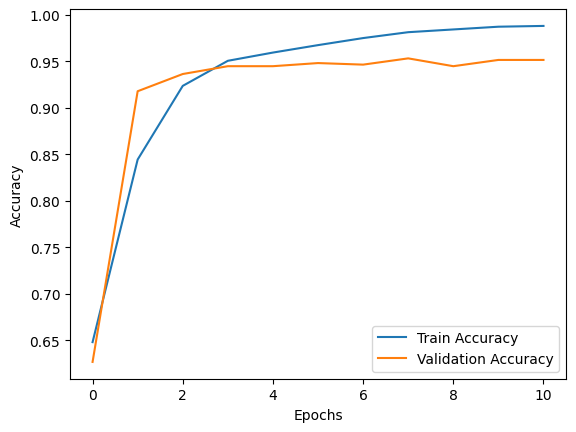

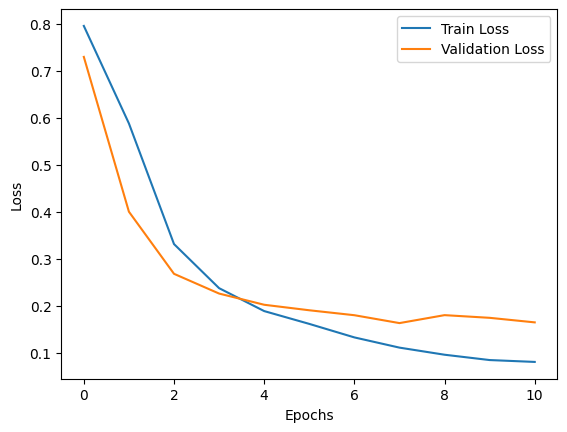

In [ ]:


# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## **Draft**

In [ ]:
# ## CNN
# from keras.models import Sequential
# from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=64, input_length=50),
#     Conv1D(filters=128, kernel_size=5, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dense(32, activation='relu'),
#     Dense(len(set(newDS1['Type'])), activation='softmax')  # Multi-class classification
# ])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ## CNN with LSTM
# from keras.models import Sequential
# from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense

# model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=64, input_length=50),
#     Conv1D(filters=128, kernel_size=5, activation='relu'),
#     GlobalMaxPooling1D(),
#     LSTM(64, return_sequences=False),
#     Dense(32, activation='relu'),
#     Dense(len(set(newDS1['Type'])), activation='softmax')  # Multi-class classification
# ])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# import pandas as pd
# from datasets import Dataset
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

# # Sample data (make sure your dataset contains both features and labels)

# df = pd.DataFrame(newDS1.copy())

# # Encode the labels using LabelEncoder
# label_encoder = LabelEncoder()
# df['Type'] = label_encoder.fit_transform(df['Type'])  # Encoding labels as integers

# # Split data into train and test
# train_texts, eval_texts, train_labels, eval_labels = train_test_split(df['Requirement'], df['Type'], test_size=0.2, random_state=42)

# # Convert train and test DataFrames into Hugging Face Dataset format
# train_dataset = pd.DataFrame({'Requirement': train_texts, 'labels': train_labels})
# eval_dataset = pd.DataFrame({'Requirement': eval_texts, 'labels': eval_labels})

# # Convert DataFrame to Dataset using `Dataset.from_pandas`
# train_dataset = Dataset.from_pandas(train_dataset)
# eval_dataset = Dataset.from_pandas(eval_dataset)

# # Load a tokenizer and model for sequence classification
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

# # Tokenize the dataset (ensure tokenization is applied to the 'Requirement' column)
# def tokenize_function(examples):
#     return tokenizer(examples['Requirement'], padding=True, truncation=True, max_length=128)

# train_dataset = train_dataset.map(tokenize_function, batched=True)
# eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# # Define TrainingArguments for Trainer
# training_args = TrainingArguments(
#     output_dir="./results",
#     num_train_epochs=3,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     evaluation_strategy="epoch",
#     logging_dir="./logs",
#     save_steps=10_000,
#     logging_steps=200,
#     report_to="none",
# )

# # Initialize the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset
# )

# # Train the model
# trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/781 [00:00<?, ? examples/s]

Map:   0%|          | 0/196 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [294]:
def check_duplicates(dataset_copy):
    duplicate_rows = dataset_copy[dataset_copy.duplicated()]
    print(f"\nNumber of Duplicate Rows: {len(duplicate_rows)}")
    print("Duplicate Rows:")
    print(duplicate_rows)

    return duplicate_rows
duplicate_rows = check_duplicates(dataset_copy)



Number of Duplicate Rows: 1024
Duplicate Rows:
     Type                                        Requirement  \
1092  NFR  Working with energy efficiency and low battery...   
1093  NFR  Localization and multiple language support for...   
1096  NFR  Creating an effective communication and suppor...   
1114  NFR  Working with energy efficiency and low battery...   
1128  NFR           High performance and fast response times   
...   ...                                                ...   
2620  NFR  User access should be limited to the permissio...   
2621  NFR  The product must comply with the intranet page...   
2622  NFR  The intranet pages should display appropriatel...   
2623  NFR  The users should be able to easily use the sys...   
2624  NFR  The product interface should be fast. The resp...   

      Requirement_Length  Word_Count  Character_Count  
1092                  58           8               58  
1093                  88          11               88  
1096           